In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from exod.utils.path import data_raw, data_processed

# Load Events list
event_file = '../data/processed/0001730201/P0001730201PNU002PIEVLI0000_FILT.fits'

instrument = fits.open(event_file)[0].header['INSTRUME'] # ['EMOS1', 'EMOS2', 'EPN']
tab        = Table.read(event_file, hdu=1)
df         = tab.to_pandas()
df

,TIME,RAWX,RAWY,DETX,DETY,X,Y,PHA,PI,FLAG,PATTERN,PAT_ID,PAT_SEQ,CCDNR,TIME_RAW
0,1.005324e+08,25,66,-4272,10023,28561,34660,1586,7997,0,0,0,0,1,1.005324e+08
1,1.005324e+08,44,105,-5865,6808,30367,31560,598,3205,0,0,0,0,1,1.005324e+08
2,1.005324e+08,28,35,-4494,12611,28607,37257,510,4083,0,1,5121,0,1,1.005324e+08
3,1.005324e+08,9,159,-2941,2355,27751,26920,779,4056,0,0,0,0,1,1.005324e+08
4,1.005324e+08,35,107,-5081,6654,29596,31354,829,4292,0,0,0,0,1,1.005324e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421046,1.005551e+08,14,167,-17220,-3899,<NA>,<NA>,980,5057,0,0,0,0,12,1.005551e+08
421047,1.005551e+08,1,84,-18262,-10793,<NA>,<NA>,559,3055,65541,1,1,0,12,1.005551e+08
421048,1.005551e+08,51,70,-14153,-11902,<NA>,<NA>,1682,7993,0,0,0,0,12,1.005551e+08
421049,1.005551e+08,55,12,-13854,-16689,<NA>,<NA>,40,311,65537,1,1,0,12,1.005551e+08


In [2]:
# Filter only 1 CCD and set the start time to 0
df = df[df['CCDNR'] == 4]
df['TIME'] = df['TIME'] - df['TIME'].min()

# Only include columns we need
df = df[['TIME', 'RAWX', 'RAWY', 'PI']]
df

/tmp/ipykernel_732916/2637875109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIME'] = df['TIME'] - df['TIME'].min()


,TIME,RAWX,RAWY,PI
90993,0.000000,25,174,829
90994,0.243980,9,147,3444
90995,0.261727,35,191,553
90996,0.384267,49,149,7961
90997,0.697233,36,191,780
...,...,...,...,...
176891,22758.493019,10,113,1729
176892,22758.464754,36,193,853
176893,22758.933715,60,113,3552
176894,22758.955087,8,135,8668


In [3]:
t_bin_size = 20
box_size   = 3
x_max = 69
y_max = 203

t_0, t_f   = df['TIME'].min(), df['TIME'].max()
t_bins     = t_bins = np.arange(t_0, t_f + t_bin_size, t_bin_size)
x_bins     = np.arange(0, x_max+box_size, box_size)
y_bins     = np.arange(0, y_max+box_size, box_size)

N_t_bins   = len(t_bins)
N_y_bins   = len(y_bins)
N_x_bins   = len(x_bins)

cube_size = N_t_bins * N_y_bins * N_x_bins
print(N_t_bins, N_y_bins, N_x_bins, cube_size)


# Group photons into time windows, and boxes
df['RAWX_GROUP'] = pd.cut(df['RAWX'], bins=x_bins)
df['RAWY_GROUP'] = pd.cut(df['RAWY'], bins=y_bins)
df['XY_BOX']     = df['RAWX_GROUP'].astype(str) + '_' + df['RAWY_GROUP'].astype(str)
df['TIME_BIN']   = pd.cut(df['TIME'], bins=t_bins, right=False)
df


1139 69 24 1886184


,TIME,RAWX,RAWY,PI,RAWX_GROUP,RAWY_GROUP,XY_BOX,TIME_BIN
90993,0.000000,25,174,829,"(24, 27]","(171, 174]","(24, 27]_(171, 174]","[0.0, 20.0)"
90994,0.243980,9,147,3444,"(6, 9]","(144, 147]","(6, 9]_(144, 147]","[0.0, 20.0)"
90995,0.261727,35,191,553,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)"
90996,0.384267,49,149,7961,"(48, 51]","(147, 150]","(48, 51]_(147, 150]","[0.0, 20.0)"
90997,0.697233,36,191,780,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)"
...,...,...,...,...,...,...,...,...
176891,22758.493019,10,113,1729,"(9, 12]","(111, 114]","(9, 12]_(111, 114]","[22740.0, 22760.0)"
176892,22758.464754,36,193,853,"(33, 36]","(192, 195]","(33, 36]_(192, 195]","[22740.0, 22760.0)"
176893,22758.933715,60,113,3552,"(57, 60]","(111, 114]","(57, 60]_(111, 114]","[22740.0, 22760.0)"
176894,22758.955087,8,135,8668,"(6, 9]","(132, 135]","(6, 9]_(132, 135]","[22740.0, 22760.0)"


In [4]:
df = df[~df['RAWX_GROUP'].isna()]
df

,TIME,RAWX,RAWY,PI,RAWX_GROUP,RAWY_GROUP,XY_BOX,TIME_BIN
90993,0.000000,25,174,829,"(24, 27]","(171, 174]","(24, 27]_(171, 174]","[0.0, 20.0)"
90994,0.243980,9,147,3444,"(6, 9]","(144, 147]","(6, 9]_(144, 147]","[0.0, 20.0)"
90995,0.261727,35,191,553,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)"
90996,0.384267,49,149,7961,"(48, 51]","(147, 150]","(48, 51]_(147, 150]","[0.0, 20.0)"
90997,0.697233,36,191,780,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)"
...,...,...,...,...,...,...,...,...
176891,22758.493019,10,113,1729,"(9, 12]","(111, 114]","(9, 12]_(111, 114]","[22740.0, 22760.0)"
176892,22758.464754,36,193,853,"(33, 36]","(192, 195]","(33, 36]_(192, 195]","[22740.0, 22760.0)"
176893,22758.933715,60,113,3552,"(57, 60]","(111, 114]","(57, 60]_(111, 114]","[22740.0, 22760.0)"
176894,22758.955087,8,135,8668,"(6, 9]","(132, 135]","(6, 9]_(132, 135]","[22740.0, 22760.0)"


In [6]:
box_data

NameError: name 'box_data' is not defined

In [7]:
from tqdm import tqdm

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame

# Extract unique boxes
unique_boxes = df['XY_BOX'].unique()

# Perform DBSCAN clustering for each unique box
for box in tqdm(unique_boxes):
    # Select data for the current box
    box_data = df[df['XY_BOX'] == box][['TIME']]

    # Standardize the data
    scaler = StandardScaler()
    box_data_scaled = scaler.fit_transform(box_data)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=0.05, min_samples=10)
    labels = dbscan.fit_predict(box_data_scaled)

    # Add the cluster labels to the original DataFrame
    df.loc[df['XY_BOX'] == box, 'CLUSTER_LABEL'] = labels

df[['XY_BOX', 'TIME', 'CLUSTER_LABEL']]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1408/1408 [00:18<00:00, 75.11it/s]


,XY_BOX,TIME,CLUSTER_LABEL
90993,"(24, 27]_(171, 174]",0.000000,-1.0
90994,"(6, 9]_(144, 147]",0.243980,-1.0
90995,"(33, 36]_(189, 192]",0.261727,0.0
90996,"(48, 51]_(147, 150]",0.384267,-1.0
90997,"(33, 36]_(189, 192]",0.697233,0.0
...,...,...,...
176891,"(9, 12]_(111, 114]",22758.493019,-1.0
176892,"(33, 36]_(192, 195]",22758.464754,0.0
176893,"(57, 60]_(111, 114]",22758.933715,-1.0
176894,"(6, 9]_(132, 135]",22758.955087,-1.0


In [9]:
df['CLUSTER_LABEL'].value_counts()

CLUSTER_LABEL
-1.0     47858
 0.0     31583
 1.0      1695
 2.0      1182
 3.0       992
 4.0       640
 6.0       500
 5.0       465
 7.0       410
 8.0       261
 9.0       122
 10.0      108
 11.0       58
 12.0       29
Name: count, dtype: int64

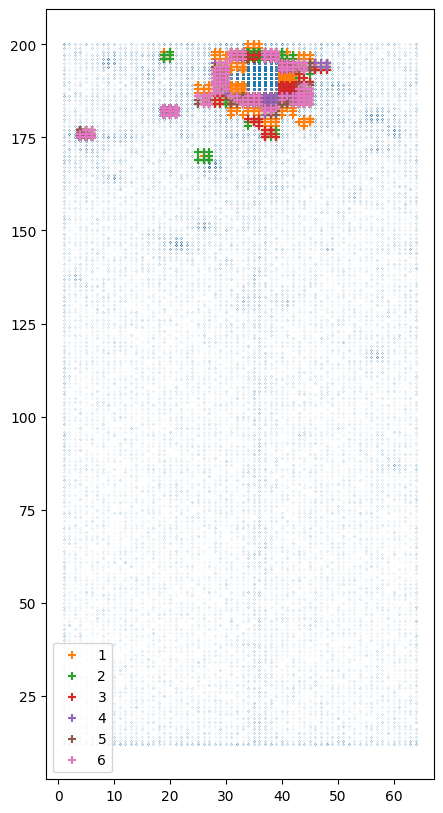

In [10]:
plt.figure(figsize=(5,10))
plt.scatter(df['RAWX'], df['RAWY'], s=0.001)
for i in range(1,7):
    df_lab = df[df['CLUSTER_LABEL'] == i]
    plt.scatter(df_lab['RAWX'], df_lab['RAWY'], marker='+', label=f'{i}')
plt.legend()
plt.show()


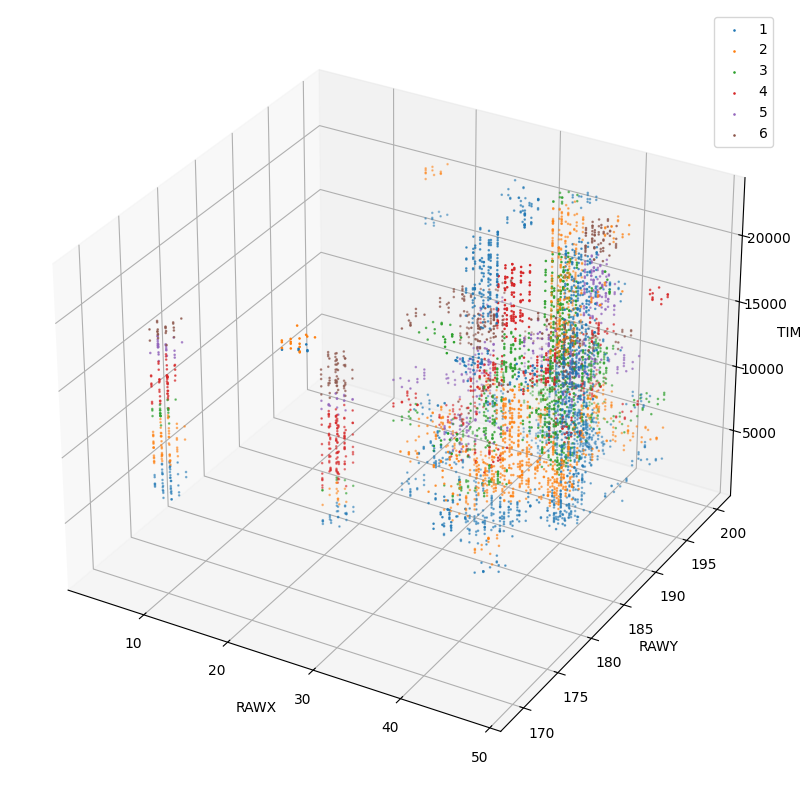

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(1,7):
    df_lab = df[df['CLUSTER_LABEL'] == i]
    ax.scatter(df_lab['RAWX'], df_lab['RAWY'], df_lab['TIME'], marker='.', label=f'{i}', s=3)
    
ax.set_xlabel('RAWX')
ax.set_ylabel('RAWY')
ax.set_zlabel('TIME')
ax.legend()
plt.show()


In [12]:
# Count the number of photons in each time_window + bin combination
# Using observed=True  will only return those groups that had values
# Using observed=False will return all combinations even if they did not have counts
df_sub = df[['TIME_BIN','XY_BOX', 'PI']]
box_counts = df_sub.groupby(['TIME_BIN', 'XY_BOX'], observed=True).count().reset_index()
box_counts

,TIME_BIN,XY_BOX,PI
0,"[0.0, 20.0)","(0, 3]_(156, 159]",1
1,"[0.0, 20.0)","(12, 15]_(174, 177]",1
2,"[0.0, 20.0)","(12, 15]_(54, 57]",1
3,"[0.0, 20.0)","(18, 21]_(189, 192]",1
4,"[0.0, 20.0)","(21, 24]_(144, 147]",1
...,...,...,...
60634,"[22740.0, 22760.0)","(6, 9]_(123, 126]",1
60635,"[22740.0, 22760.0)","(6, 9]_(132, 135]",1
60636,"[22740.0, 22760.0)","(63, 66]_(45, 48]",1
60637,"[22740.0, 22760.0)","(9, 12]_(111, 114]",1


In [13]:
# Merge the result back with the original DataFrame based on 'TIME_BIN' and 'XY_BOX'
result_df = pd.merge(df, box_counts, on=['TIME_BIN', 'XY_BOX'], how='right', suffixes=('_original', '_count'))
result_df = result_df.drop(columns=['PI_count'])
result_df

,TIME,RAWX,RAWY,PI_original,RAWX_GROUP,RAWY_GROUP,XY_BOX,TIME_BIN,CLUSTER_LABEL
0,19.428356,1,159,1228,"(0, 3]","(156, 159]","(0, 3]_(156, 159]","[0.0, 20.0)",-1.0
1,14.577010,13,175,1707,"(12, 15]","(174, 177]","(12, 15]_(174, 177]","[0.0, 20.0)",-1.0
2,2.465772,14,57,356,"(12, 15]","(54, 57]","(12, 15]_(54, 57]","[0.0, 20.0)",-1.0
3,8.524546,21,191,1153,"(18, 21]","(189, 192]","(18, 21]_(189, 192]","[0.0, 20.0)",-1.0
4,9.930054,22,146,4878,"(21, 24]","(144, 147]","(21, 24]_(144, 147]","[0.0, 20.0)",-1.0
...,...,...,...,...,...,...,...,...,...
85898,22746.863227,7,126,1694,"(6, 9]","(123, 126]","(6, 9]_(123, 126]","[22740.0, 22760.0)",-1.0
85899,22758.955087,8,135,8668,"(6, 9]","(132, 135]","(6, 9]_(132, 135]","[22740.0, 22760.0)",-1.0
85900,22742.777442,64,47,238,"(63, 66]","(45, 48]","(63, 66]_(45, 48]","[22740.0, 22760.0)",-1.0
85901,22758.493019,10,113,1729,"(9, 12]","(111, 114]","(9, 12]_(111, 114]","[22740.0, 22760.0)",-1.0


In [14]:
# Extract X, Y low and high values for each photon
box_counts_split = box_counts['XY_BOX'].str.extract(r'\((\d+), (\d+)\]\_\((\d+), (\d+)\]').astype(int)
box_counts_split.columns = ['X_LO', 'X_HI', 'Y_LO', 'Y_HI']
box_counts_split['VAL'] = box_counts['PI'] # Add column with number of detected photons
box_counts_split

,X_LO,X_HI,Y_LO,Y_HI,VAL
0,0,3,156,159,1
1,12,15,174,177,1
2,12,15,54,57,1
3,18,21,189,192,1
4,21,24,144,147,1
...,...,...,...,...,...
60634,6,9,123,126,1
60635,6,9,132,135,1
60636,63,66,45,48,1
60637,9,12,111,114,1


Number of image frames=1135


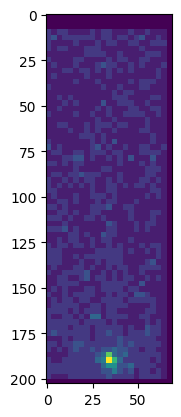

In [15]:

image_arrays = []
for time_bin in box_counts['TIME_BIN'].unique():
    image_size = (y_max, x_max)
    image_array = np.zeros(image_size, dtype=int)
    
    box_counts_time_bin = box_counts_split[box_counts['TIME_BIN'] == time_bin]
    for index, row in box_counts_time_bin.iterrows():
        image_array[row['Y_LO']:row['Y_HI'], row['X_LO']:row['X_HI']] = row['VAL']
    image_arrays.append(image_array)
    #plt.title(time_bin)
    #plt.imshow(image_array)
    #plt.show()
image_arrays = np.array(image_arrays)

print(f'Number of image frames={len(image_arrays)}')


c_max = np.max(image_arrays, axis=0)
c_median = np.median(image_arrays, axis=0)
c_min = np.min(image_arrays, axis=0)
c_median_nonzero = np.where(c_median == 0, 1, c_median)
V = np.maximum(c_max - c_median, c_median - c_min)

plt.imshow(V,  interpolation='none') # norm=LogNorm(),
#plt.xlim(0,64)
#plt.ylim(3,200)
plt.show()



In [16]:
image_size = (y_max, x_max)
V_array = np.zeros(image_size, dtype=int)
hit_array = np.zeros(image_size, dtype=int)

In [17]:
for i, row in box_counts_split.iterrows():
    V_array[row['Y_LO']:row['Y_HI'], row['X_LO']:row['X_HI']] += row['VAL']
    hit_array[row['Y_LO']:row['Y_HI'], row['X_LO']:row['X_HI']] += 1
    

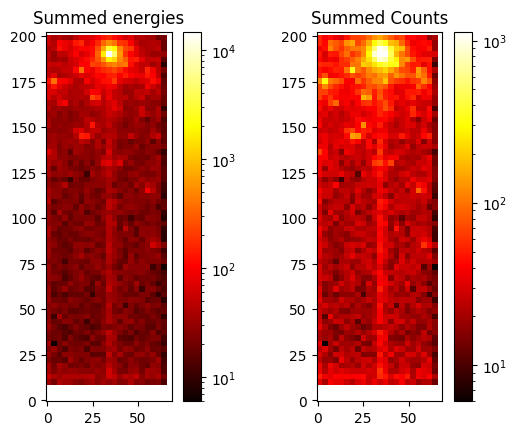

In [18]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,2)
ax[0].set_title('Summed energies')
m1 = ax[0].imshow(V_array, norm=LogNorm(), interpolation='none', origin='lower', cmap='hot')
plt.colorbar(m1, ax=ax[0])
ax[1].set_title('Summed Counts')
m2 = ax[1].imshow(hit_array, norm=LogNorm(), interpolation='none', origin='lower', cmap='hot')
plt.colorbar(m2, ax=ax[1])


In [19]:
df

,TIME,RAWX,RAWY,PI,RAWX_GROUP,RAWY_GROUP,XY_BOX,TIME_BIN,CLUSTER_LABEL
90993,0.000000,25,174,829,"(24, 27]","(171, 174]","(24, 27]_(171, 174]","[0.0, 20.0)",-1.0
90994,0.243980,9,147,3444,"(6, 9]","(144, 147]","(6, 9]_(144, 147]","[0.0, 20.0)",-1.0
90995,0.261727,35,191,553,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)",0.0
90996,0.384267,49,149,7961,"(48, 51]","(147, 150]","(48, 51]_(147, 150]","[0.0, 20.0)",-1.0
90997,0.697233,36,191,780,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)",0.0
...,...,...,...,...,...,...,...,...,...
176891,22758.493019,10,113,1729,"(9, 12]","(111, 114]","(9, 12]_(111, 114]","[22740.0, 22760.0)",-1.0
176892,22758.464754,36,193,853,"(33, 36]","(192, 195]","(33, 36]_(192, 195]","[22740.0, 22760.0)",0.0
176893,22758.933715,60,113,3552,"(57, 60]","(111, 114]","(57, 60]_(111, 114]","[22740.0, 22760.0)",-1.0
176894,22758.955087,8,135,8668,"(6, 9]","(132, 135]","(6, 9]_(132, 135]","[22740.0, 22760.0)",-1.0


In [20]:
df

,TIME,RAWX,RAWY,PI,RAWX_GROUP,RAWY_GROUP,XY_BOX,TIME_BIN,CLUSTER_LABEL
90993,0.000000,25,174,829,"(24, 27]","(171, 174]","(24, 27]_(171, 174]","[0.0, 20.0)",-1.0
90994,0.243980,9,147,3444,"(6, 9]","(144, 147]","(6, 9]_(144, 147]","[0.0, 20.0)",-1.0
90995,0.261727,35,191,553,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)",0.0
90996,0.384267,49,149,7961,"(48, 51]","(147, 150]","(48, 51]_(147, 150]","[0.0, 20.0)",-1.0
90997,0.697233,36,191,780,"(33, 36]","(189, 192]","(33, 36]_(189, 192]","[0.0, 20.0)",0.0
...,...,...,...,...,...,...,...,...,...
176891,22758.493019,10,113,1729,"(9, 12]","(111, 114]","(9, 12]_(111, 114]","[22740.0, 22760.0)",-1.0
176892,22758.464754,36,193,853,"(33, 36]","(192, 195]","(33, 36]_(192, 195]","[22740.0, 22760.0)",0.0
176893,22758.933715,60,113,3552,"(57, 60]","(111, 114]","(57, 60]_(111, 114]","[22740.0, 22760.0)",-1.0
176894,22758.955087,8,135,8668,"(6, 9]","(132, 135]","(6, 9]_(132, 135]","[22740.0, 22760.0)",-1.0


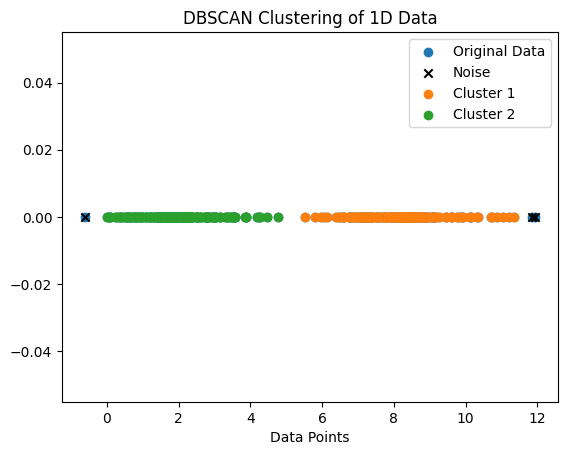

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Generate 1D data with two clusters and some noise
X, _ = make_blobs(n_samples=300, centers=[[2], [8]], cluster_std=1.0, random_state=42)

# Add some noise
noise = np.random.uniform(low=0, high=12, size=(30, 1))
X = np.concatenate([X, noise])

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Plot the original data
plt.scatter(X, np.zeros_like(X), label='Original Data')

# Plot the clustered data
unique_labels = np.unique(labels)
for label in unique_labels:
    if label == -1:
        plt.scatter(X[labels == label], np.zeros_like(X[labels == label]), label='Noise', marker='x', c='black')
    else:
        plt.scatter(X[labels == label], np.zeros_like(X[labels == label]), label=f'Cluster {label + 1}')

plt.title('DBSCAN Clustering of 1D Data')
plt.xlabel('Data Points')
plt.legend()
plt.show()


In [22]:
poi_idx

NameError: name 'poi_idx' is not defined

In [ ]:
poi_samp = np.random.poisson(lam=0.01, size=100000)
poi_idx  = np.where(poi_samp>0)[0]
poi_toa  = poi_idx * 73.4E-3
poi_toa  = poi_toa.reshape(-1,1)

In [ ]:
# Generate 1D data with two clusters and some noise
X, _ = make_blobs(n_samples=1000, centers=[[2000], [4000]], cluster_std=10)

noise = np.random.uniform(low=0, high=25000, size=(10,1))
X_sum = np.concatenate([X, poi_toa])
# Plot the original data
plt.scatter(X_sum, np.zeros_like(X_sum), label='Data', marker='.')
plt.scatter(X, np.zeros_like(X), label='Burst', marker='.')


dbscan = DBSCAN(eps=0.1, min_samples=10)
labels = dbscan.fit_predict(X)

# Plot the clustered data
unique_labels = np.unique(labels)
for i, label in enumerate(unique_labels):
    if label == -1:
        plt.scatter(X[labels == label], i+np.zeros_like(X[labels == label]), label='Noise', marker='x', c='black')
    else:
        plt.scatter(X[labels == label], i+np.zeros_like(X[labels == label]), label=f'Cluster {label + 1}')

plt.xlabel('Time')
plt.legend()
plt.show()
